In [1]:
# setup environment
import numpy as np
import pandas as pd
from scipy import stats
import sqlite3

from sklearn.feature_selection import mutual_info_classif

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() # I like seaborn default theme

# suppress warning messages
import warnings
warnings.filterwarnings("ignore")

data_path = './data/' # relative path to the data folder

## Import raw data

If data is too big, it is better to do basic cleaning, transformation and analysis by SQL, before loading into Python. The given data table is quite small (15,900 x 18), so we can directly load all data into Python as a DataFrame.

In [2]:
# import raw data from database to DataFrame
conn = sqlite3.connect(data_path + 'score.db') # connection to db
query = f"SELECT * FROM score"
df_raw = pd.read_sql_query(query, conn) # DataFrame of raw data
conn.close() # close the connection

# show first few rows of raw data
df_raw.head()

,index,number_of_siblings,direct_admission,CCA,learning_style,student_id,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport,bag_color
0,0,0,Yes,Sports,Visual,ACN2BE,Female,No,69.0,14.0,2.0,16.0,10.0,91.0,22:00,6:00,private transport,yellow
1,1,2,No,Sports,Auditory,FGXIIZ,Female,No,47.0,4.0,19.0,16.0,7.0,94.0,22:30,6:30,private transport,green
2,2,0,Yes,None,Visual,B9AI9F,Male,No,85.0,14.0,2.0,15.0,8.0,92.0,22:30,6:30,private transport,white
3,3,1,No,Clubs,Auditory,FEVM1T,Female,Yes,64.0,2.0,20.0,15.0,18.0,NaN,21:00,5:00,public transport,yellow
4,4,0,No,Sports,Auditory,AXZN2E,Male,No,66.0,24.0,3.0,16.0,7.0,95.0,21:30,5:30,public transport,yellow


## Data cleaning

Data cleaning is done with below steps (not necessarily in strict order):  
1. Understand basic data info (shape, dtype, etc.)
2. Find null and duplicated data, do proper treatment.
3. Find abnormal data (typo, outlier, incorrect format, etc.), do proper treatment.

Data should be ready for feature engineer and EDA after cleaning.

### Basic data info

In [3]:
# it is good practice to leave raw data untouched, so make a copy for analysis and revision
df_data = df_raw.copy()

# show data info
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15900 entries, 0 to 15899
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               15900 non-null  int64  
 1   number_of_siblings  15900 non-null  int64  
 2   direct_admission    15900 non-null  object 
 3   CCA                 15900 non-null  object 
 4   learning_style      15900 non-null  object 
 5   student_id          15900 non-null  object 
 6   gender              15900 non-null  object 
 7   tuition             15900 non-null  object 
 8   final_test          15405 non-null  float64
 9   n_male              15900 non-null  float64
 10  n_female            15900 non-null  float64
 11  age                 15900 non-null  float64
 12  hours_per_week      15900 non-null  float64
 13  attendance_rate     15122 non-null  float64
 14  sleep_time          15900 non-null  object 
 15  wake_time           15900 non-null  object 
 16  mode

- Data shape is (15900, 18).
- Column names are consistent with the list of attributes in the PDF file, except one extra column `index`.
- `final_test` and `attendance_rate` contain `null` values.

In [4]:
# verify if 'index' column is just row number
(df_data['index']!=df_data.index).sum()

0

`index` column simply contains row number. It is not useful and can be dropped.

In [5]:
# drop 'index' column
df_data.drop(columns=['index'], inplace=True)

Data with `null` value in `final_test` is useless in this study, we can safely drop them.

In [6]:
df_data.dropna(subset='final_test', ignore_index=True, inplace=True)

I prefer to generate several feature lists according to data type (numerical, discrete, categorical, etc.). It is a good practice since EDA and feature engineer usually take different approaches according to data types.

In [7]:
# feature lists
num_cols = [] # continuous data
dis_cols = [] # discrete data
cat_cols = [] # categorical data
str_cols = [] # string data
bin_cols = [] # binary data
targets = ['final_test'] # target data

# add feature name to above lists based on dtype
str_cols += df_data.select_dtypes(include='object').columns.to_list()
dis_cols += df_data.select_dtypes(include='int64').columns.to_list()
num_cols += df_data.select_dtypes(include='float64').columns.to_list()
num_cols.remove('final_test') # remove target feature

**NOTE**  
We tentatively categorize the features according to their dtype only. It may be not proper for some features (e.g. `sleep_time` should be numeric instead of categorical). We will handle it in the cleaning process later.

### String data cleaning

For all string data, it is better to trim white space and transfer all letters to lower case (unless there is special info / meaning sensitive to case) to remove some potential typo error.

In [8]:
for feature in str_cols:
    # trim white space
    # change to lower case
    # remove duplicate white space inside string
    df_data[feature] = \
        df_data[feature].str.strip().\
                         str.lower().\
                         replace(r'\s+', ' ', regex=True)
df_data[str_cols].head()

,direct_admission,CCA,learning_style,student_id,gender,tuition,sleep_time,wake_time,mode_of_transport,bag_color
0,yes,sports,visual,acn2be,female,no,22:00,6:00,private transport,yellow
1,no,sports,auditory,fgxiiz,female,no,22:30,6:30,private transport,green
2,yes,none,visual,b9ai9f,male,no,22:30,6:30,private transport,white
3,no,clubs,auditory,fevm1t,female,yes,21:00,5:00,public transport,yellow
4,no,sports,auditory,axzn2e,male,no,21:30,5:30,public transport,yellow


**Convert `sleep_time` and `wake_time` to numeric data.**  
- Though they are time, it is more convenient to convert them to float representing hours.
- For the ease of calculation in this case, the result float value is in the range (-12.0, +12.0]. (-24 if hour value is in pm.)

In [9]:
def time2hr(time_str):
    """convert time string to float representing hours.
    ## Return
    hour [float]: in the range (-12.0, +12.0], pm hours are negative
    ## Parameter
    - time_str [string]: in the form of '22:00'
    """
    time = time_str.split(':')
    hour = time[0]
    min = time[1]
    hour = float(hour) + float(min)/60.
    if hour > 12: # convert pm hour to negative
        hour -= 24
    return hour

for col in ['sleep_time', 'wake_time']: # convert to float
    df_data[col] = df_data[col].apply(time2hr)
    # put it to correct feature list
    num_cols.append(col)
    str_cols.remove(col)

# show these 2 columns are correctly converted
df_data[['sleep_time', 'wake_time']].head()

,sleep_time,wake_time
0,-2.0,6.0
1,-1.5,6.5
2,-1.5,6.5
3,-3.0,5.0
4,-2.5,5.5


Check number of unique values in each 'object' column to judge if it should be converted to binary or categorical or not.

In [10]:
df_data[str_cols].nunique(axis=0)

direct_admission         2
CCA                      4
learning_style           2
student_id           14559
gender                   2
tuition                  4
mode_of_transport        3
bag_color                6
dtype: int64

- Except `student_id`, all are binary or categorical features.
- `student_id` unique value number is smaller than total row number, indicating existence of duplicated data entry.

Print all unique values of these features (except `student_id`). Purpose is check if there is any more typo issue. Also prepare to convert them to binary or categorical dtype.

In [11]:
for col in str_cols:
    if col == 'student_id': continue # ignore this feature
    print(col, df_data[col].unique())

direct_admission ['yes' 'no']
CCA ['sports' 'none' 'clubs' 'arts']
learning_style ['visual' 'auditory']
gender ['female' 'male']
tuition ['no' 'yes' 'y' 'n']
mode_of_transport ['private transport' 'public transport' 'walk']
bag_color ['yellow' 'green' 'white' 'red' 'blue' 'black']


`tuition` has inconsistent entries and it should be binary.  
Firstly we convert all its values to 'y' or 'n'.

In [12]:
df_data['tuition'] = df_data['tuition'].str[0]
print('tuition', df_data['tuition'].unique())

tuition ['n' 'y']


Convert their dtype to 'bool' or 'category', due to below benifits:  
- Save memory
- Consistent ordering when plotting by seaborn
- Easy for future analysis (EDA, modelling, etc.)

In [13]:
# convert 'direct_admission' to binary
df_data['direct_admission'] = df_data['direct_admission'] == 'yes'
bin_cols.append('direct_admission')
str_cols.remove('direct_admission')

# convert 'tuition' to binary
df_data['tuition'] = df_data['tuition'] == 'y'
bin_cols.append('tuition')
str_cols.remove('tuition')

# convert 'learning_style' to binary
# change name to 'learn_by_visual' for readability
df_data['learn_by_visual'] = df_data['learning_style'] == 'visual'
df_data.drop(columns=['learning_style'], inplace=True)
bin_cols.append('learn_by_visual')
str_cols.remove('learning_style')

# convert 'gender' to binary
# change name to 'is_male' for readability
df_data['is_male'] = df_data['gender'] == 'male'
df_data.drop(columns=['gender'], inplace=True)
bin_cols.append('is_male')
str_cols.remove('gender')

# convert 'CCA' to category
df_data['CCA'] = pd.Categorical(values=df_data['CCA'], 
                                categories=['none', 'sports', 'clubs', 'arts'],
                                ordered=True) # order is assigned for convienence, not because it is ordinal
cat_cols.append('CCA')
str_cols.remove('CCA')

# convert 'mode_of_transport' to category
df_data['mode_of_transport'] = \
    pd.Categorical(values=df_data['mode_of_transport'], 
                   categories=['private transport', 'public transport', 'walk'],
                   ordered=True) # order is assigned for convienence, not because it is ordinal
cat_cols.append('mode_of_transport')
str_cols.remove('mode_of_transport')

# convert 'bag_color' to category
df_data['bag_color'] = \
    pd.Categorical(values=df_data['bag_color'], 
                   categories=['yellow', 'green', 'white', 'red', 'blue', 'black'],
                   ordered=True) # order is assigned for convienence, not because it is ordinal
cat_cols.append('bag_color')
str_cols.remove('bag_color')

# show their dtype are correctly converted
df_data[bin_cols + cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15405 entries, 0 to 15404
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   direct_admission   15405 non-null  bool    
 1   tuition            15405 non-null  bool    
 2   learn_by_visual    15405 non-null  bool    
 3   is_male            15405 non-null  bool    
 4   CCA                15405 non-null  category
 5   mode_of_transport  15405 non-null  category
 6   bag_color          15405 non-null  category
dtypes: bool(4), category(3)
memory usage: 106.0 KB


In [14]:
# check if 'student_id' are all string with length of 6
(df_data['student_id'].str.len()!=6).sum()

0

`student_id` is the unique ID for each student. However there are duplicate records in our data. Let's see more details:

In [15]:
print('Number of duplicated student_id =',
      df_data['student_id'].duplicated().sum())
print('Number of duplicated rows =      ',
      df_data.duplicated().sum())

Number of duplicated student_id = 846
Number of duplicated rows =       138


Big difference in above 2 values means most duplicated `student_id` data also have other feature difference.

It is safe to delete the duplicated (by all features) rows. So we do it first.

In [16]:
# drop duplicate rows and reset index
df_data = df_data.drop_duplicates().reset_index(drop=True)
df_data.shape

(15267, 17)

Now let's take a look at the rest of the duplicated `student_id` data to find out which feature is different.

In [17]:
# make a copy of all duplicated rows for easy analysis
df_duplicate = (
    df_data[df_data['student_id'].
            duplicated(keep=False)].
            sort_values(['student_id', 'attendance_rate'])
            # if null value in 'attendance_rate', it will be put at last row of the specific 'student_id'
)

print('total duplicated rows =', df_duplicate.shape[0])
print('unique student_id =', df_duplicate['student_id'].nunique())

total duplicated rows = 1416
unique student_id = 708


Total 708 `student_id` are duplicated with exactly 2 appearences each.

In [18]:
df_duplicate.head(20)

,number_of_siblings,direct_admission,CCA,student_id,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport,bag_color,learn_by_visual,is_male
5338,0,False,clubs,00811h,True,88.0,21.0,4.0,15.0,8.0,92.0,-1.0,7.0,walk,green,False,False
11828,0,False,clubs,00811h,True,88.0,21.0,4.0,15.0,8.0,92.0,-1.0,7.0,walk,white,False,False
4156,0,False,clubs,02rsah,True,64.0,12.0,9.0,15.0,17.0,97.0,-2.0,6.0,private transport,yellow,False,False
8855,0,False,clubs,02rsah,True,64.0,12.0,9.0,15.0,17.0,97.0,-2.0,6.0,private transport,green,False,False
9446,0,False,arts,0fc4ry,False,68.0,23.0,4.0,15.0,6.0,100.0,-1.0,7.0,walk,yellow,False,False
8353,0,False,arts,0fc4ry,False,68.0,23.0,4.0,15.0,6.0,NaN,-1.0,7.0,walk,blue,False,False
1376,0,True,none,0jugaf,False,84.0,18.0,2.0,16.0,10.0,94.0,-1.0,7.0,walk,red,True,False
6126,0,True,none,0jugaf,False,84.0,18.0,2.0,16.0,10.0,94.0,-1.0,7.0,walk,yellow,True,False
8840,0,True,none,0k5ldv,True,84.0,9.0,12.0,16.0,9.0,98.0,-2.0,6.0,private transport,white,False,False
15094,0,True,none,0k5ldv,True,84.0,9.0,12.0,16.0,9.0,98.0,-2.0,6.0,private transport,red,False,False


Examine above few rows we can find the inconsistent features are mainly `bag_color` and some `attendance_rate`.

Below code verifies the count of inconsistency of each feature.

In [19]:
# 1st appearence of each student_id
df1 = df_duplicate.iloc[0::2].reset_index(drop=True)
# 2nd appearence of each student_id
df2 = df_duplicate.iloc[1::2].reset_index(drop=True)
# compare difference of each feature
(df1!=df2).sum()

number_of_siblings      0
direct_admission        0
CCA                     0
student_id              0
tuition                 0
final_test              0
n_male                  0
n_female                0
age                     0
hours_per_week          0
attendance_rate        83
sleep_time              0
wake_time               0
mode_of_transport       0
bag_color             685
learn_by_visual         0
is_male                 0
dtype: int64

The result confirms that the inconsistent features are only `bag_color` and `attendance_rate`.

In [20]:
print('total null in attendance_rate =', 
      df_duplicate['attendance_rate'].isna().sum())
print('total null in inconsistent attendance_rate =',
      df2['attendance_rate'][df1['attendance_rate']!=df2['attendance_rate']].isna().sum())

total null in attendance_rate = 83
total null in inconsistent attendance_rate = 83


Above result shows that the inconsistency in `attendance_rate` is purely due to `null` value in the 2nd appearence. So simply drop the 2nd appearence is OK.

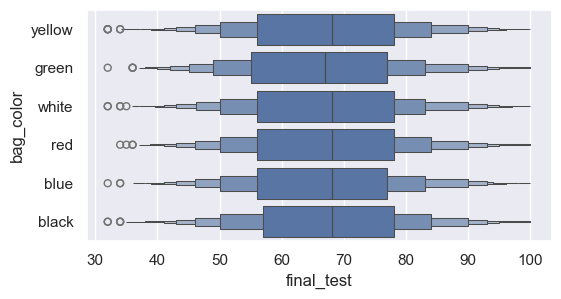

In [21]:
# plot: bag_color effect on final_test
fig = plt.figure(figsize=(6, 3))
sns.boxenplot(df_data, x='final_test', y='bag_color')
plt.show()

Regarding the inconsistent `bag_color` data, there are 2 possible solutions:  
1. Drop all inconsistent data.
2. Choose to keep one data.

Above plot shows that `bag_color` feature is NOT a strong indicator of `final_test`, the 2nd solution is likely a better choice.

My final decision is to keep all the 1st appearence of each `student_id`

In [22]:
df_data = (
    df_data.sort_values('attendance_rate') # make sure null values appear only at 2nd appearence
           .drop_duplicates('student_id', ignore_index=True)
)
df_data.duplicated().sum()


0

Now all duplicated rows are removed. 'student_id' is no longer needed in future analysis, so we drop this column.

In [23]:
df_data.drop(columns=['student_id'], inplace=True)
str_cols.remove('student_id')

### Numeric data cleaning

The strategy to clean numeric data is to check **range** and **distribution** of each of feature, find out unreasonable inputs or outliers.

I have checked all of them. To save your time I only highlight the significant findings below:

In [24]:
df_data['age'].value_counts()

age
 16.0    7082
 15.0    7057
 6.0      216
 5.0      199
-5.0        4
-4.0        1
Name: count, dtype: int64

`age` column has abnormal records. In real work environment we have to check with data owner on the cause and discuss with stake owners on whether to drop these abnormal data or not.

Here I dicide to correct the records with below assumptions:  
- 6 and 5 are actually 16 and 15
- -5 and -4 are difference from 20, so they are actually 15 and 16

Also we better convert `age` dtype to `int` and treat it as discrete values.

In [25]:
def correct_age(x):
    """Correct age value and convert to integer"""
    if x < 0:
        y = x + 20
    elif x < 10:
        y = x + 10
    else:
        y = x
    return int(y)

df_data['age'] = df_data['age'].apply(correct_age)
# treat 'age' as discrete instead of continuous values
dis_cols.append('age')
num_cols.remove('age')

In [26]:
num_null = df_data['attendance_rate'].isna().sum()
print('Number of null values in attendance_rate =', num_null)
print(f'Null ratio = {num_null/df_data.shape[0]:.1%}')

Number of null values in attendance_rate = 674
Null ratio = 4.6%


`attendance_rate` column has 4.6% null ratio, which is quite significant. Potentially this feature has high prediction power on test result, we may consider below approaches to treat it when building models:  
1. **Drop all null rows**. We will lose 4.6% data, which is not very high. Hopefully it will not significant affect model quality.
2. **Fill** null values by **mean or median** of all other samples. If use this method, I suggest to **add** another binary feature `null_attendance` to mark if attendance rate data is initially null or not.
3. Build a model to use other features to predict `attendance_rate`, then fill its nulls using the predictions from this model

For this EDA, I will not touch these null values.

## Feature Engineer & EDA

Let's add some new features.

In [27]:
df_data['class_size'] = df_data['n_female'] + df_data['n_male']
df_data['male_ratio'] = df_data['n_male'] / df_data['class_size']
df_data['sleep_length'] = df_data['wake_time'] - df_data['sleep_time']
num_cols = num_cols + ['class_size', 'male_ratio', 'sleep_length']
df_data[['class_size', 'male_ratio', 'sleep_length']].describe()

,class_size,male_ratio,sleep_length
count,14559.000000,14559.000000,14559.000000
mean,22.778350,0.613830,7.847517
std,4.234682,0.271798,0.599577
min,14.000000,0.000000,4.000000
25%,20.000000,0.444444,8.000000
50%,22.000000,0.647059,8.000000
75%,27.000000,0.833333,8.000000
max,31.000000,1.000000,8.000000


`n_male` and `n_female` are covered by `class_size` and `male_ratio`, we can drop them.

In [28]:
df_data.drop(columns=['n_male', 'n_female'], inplace=True)
num_cols.remove('n_male')
num_cols.remove('n_female')

### Feature distribution & relationship to target
#### 1. Target feature

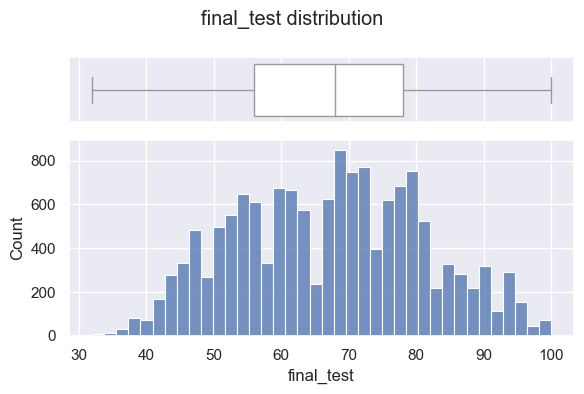

In [29]:
fig, axs = plt.subplots(2, 1, sharex=True, 
                        height_ratios=[1,3], figsize=(6, 4))
sns.boxplot(df_data, x='final_test', ax=axs[0], color='white')
sns.histplot(df_data, x='final_test', ax=axs[1])
fig.suptitle('final_test distribution')
fig.tight_layout()
plt.show()

`final_test` shows normal distribution without outlier.

#### 2. Continuous features

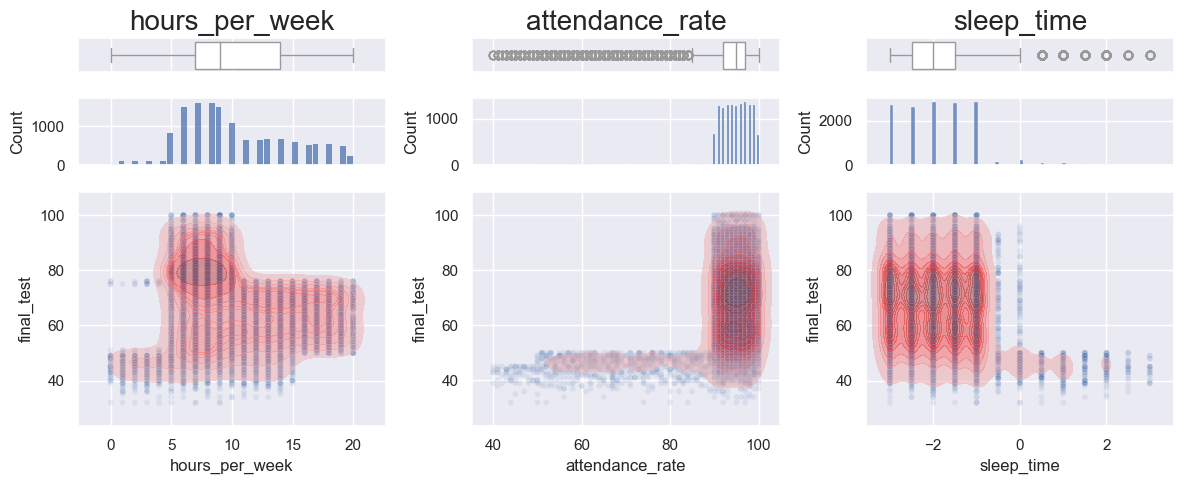

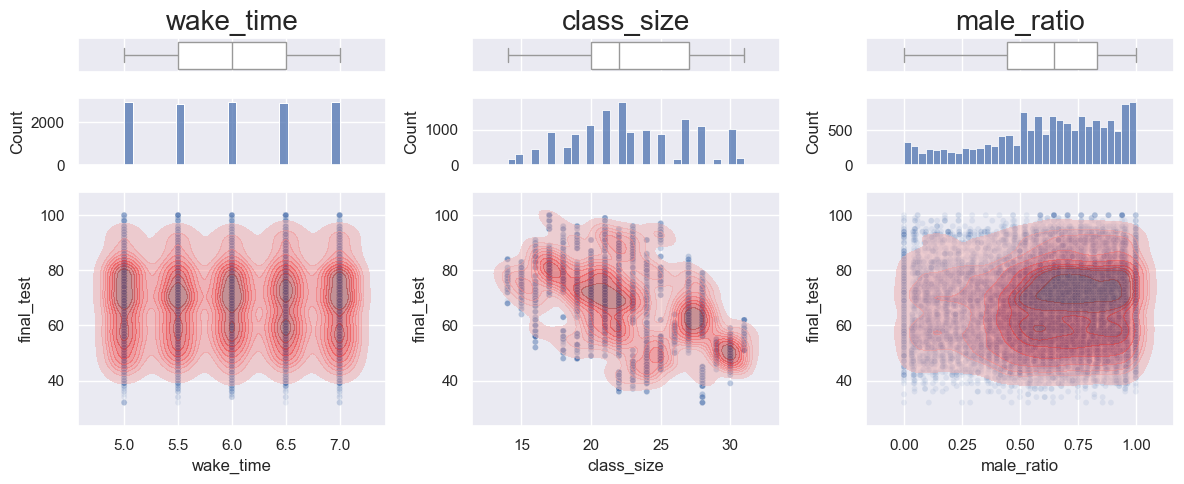

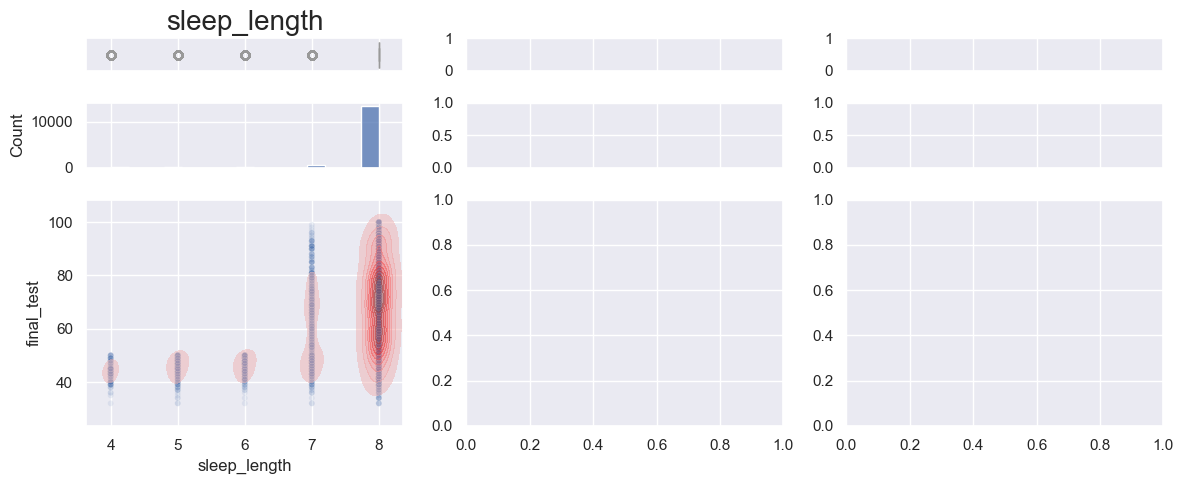

In [30]:
def plot_num_cols(features):
    """Plot distribution of continuous features (max 3)"""
    fig, axs = plt.subplots(
        nrows=3,
        ncols=3,
        sharex='col',
        height_ratios=[.5, 1, 3.5],
        figsize=(12, 5)
    )
    for i in range(len(features)):
        feature = features[i]
        ax0 = axs[0, i] # boxplot
        ax1 = axs[1, i] # histgram
        ax2 = axs[2, i] # scatter & kde
        sns.boxplot(df_data, x=feature, color='white', ax=ax0)
        sns.histplot(df_data, x=feature, ax=ax1)
        sns.scatterplot(
            data=df_data,
            x=feature,
            y='final_test',
            size=1,
            ax=ax2,
            alpha=.1
        )
        ax2.get_legend().remove()
        sns.kdeplot(
            data=df_data,
            x=feature,
            y='final_test',
            color='tab:red',
            ax=ax2,
            fill=True,
            alpha=.5
        )
        ax0.set_title(feature, fontsize=20)
    fig.tight_layout()
    plt.show()

plot_num_cols(num_cols[:3])
plot_num_cols(num_cols[3:6])
plot_num_cols(num_cols[6:])

- `hours_per_week` **strong** prediction power
    - No outlier, but can clearly break into 4 groups:
        - 0 ~ 4 hrs: mostly very low score (<50), but some can get mediocre score (~75).
        - 5 ~ 10 hrs: score distribute in the whole range.
        - 11 ~ 15 hrs: score < 80
        - 16 ~ 20 hrs: score in the range (50, 80) 
    - We can make a new feature `study_hrs` with 4 categories `short`, `norm`, `long`, `longer` according to above groups.
    - Smart students don't need to study for long time (>10), but cannot show full potential when study is not enough (<5).
    - Normal quality students perform better with longer study time.
    - Low quality students must study very long time to achieve mediocre performance.
- `attendance_rate` **strong** prediction power
    - Main distribution in the range of 90 ~ 100, with outliers of low attendance.
    - Its correlation with test score clearly shows 3 groups.
    - We can make a new feature `attendance` with 3 categories `min` (<50), `low` (<90), `norm`
    - Students delibrately avoid school always perform poorly.
- `sleep_time` **strong** prediction power
    - Main distribution in the range of -3 ~ -1 (9pm ~ 11pm), with outliers of late sleep time.
    - Its correlation with test score clearly shows 3 groups
    - We can make a new feature `bed_time` with 3 categories `early` (<11:30pm), `norm` (11:30pm ~ 12:00am), `late` (>12:00am)
    - Top performance students sleep early.
    - Late sleepers perform very poorly.
- `sleep_length` **strong** prediction power
    - Majority sleep for 8 hours, with outliers of less sleep
    - We can make a new binary feature `enough_sleep` (>=7)
    - Students without enough sleep perform very poorly
- `class_size` **strong** prediction power
    - There is trend that students in smaller class size.
- `male_ratio` **medium** prediction power
    - By itself not a strong predictor due to no linear correlation with target.
    - Nonlinear pattern can be found, especially the score distribution seems narrower when male ratio is higher.
- `wake_time` shows **weak** prediction power

In [31]:
# generate new features according to above discussion
## creat 'study_hrs'
def create_study_hrs(h):
    """convert hours_per_week to study_hrs, for single value"""
    if h < 5: return 'short'
    elif h <= 10: return 'mid'
    elif h <= 15: return 'long'
    else: return 'longer'
df_data['study_hrs'] = df_data['hours_per_week'].apply(create_study_hrs)
df_data['study_hrs'] = ( # string --> category
    pd.Categorical(df_data['study_hrs'],
                   ['short', 'mid', 'long', 'longer'],
                   ordered=True)
)
cat_cols.append('study_hrs')
## creat 'attendance'
def create_attendance(rate):
    """convert attendance_rate to attendance, for single value"""
    if rate < 50: return 'min'
    elif rate < 90: return 'low'
    else: return 'norm'
df_data['attendance'] = df_data['attendance_rate'].apply(create_attendance)
df_data['attendance'] = ( # string --> category
    pd.Categorical(df_data['attendance'],
                   ['min', 'low', 'norm'],
                   ordered=True)
)
cat_cols.append('attendance')
## creat 'bed_time'
def create_bed_time(t):
    """convert sleep_time to bed_time, for single value"""
    if t < -0.5: return 'early'
    elif t <= 0: return 'norm'
    else: return 'late'
df_data['bed_time'] = df_data['sleep_time'].apply(create_bed_time)
df_data['bed_time'] = ( # string --> category
    pd.Categorical(df_data['bed_time'],
                   ['early', 'norm', 'late'],
                   ordered=True)
)
cat_cols.append('bed_time')
## creat 'enough_sleep'
df_data['enough_sleep'] = df_data['sleep_length'] >= 7
bin_cols.append('enough_sleep')

#### 3. Discrete, binary & category features

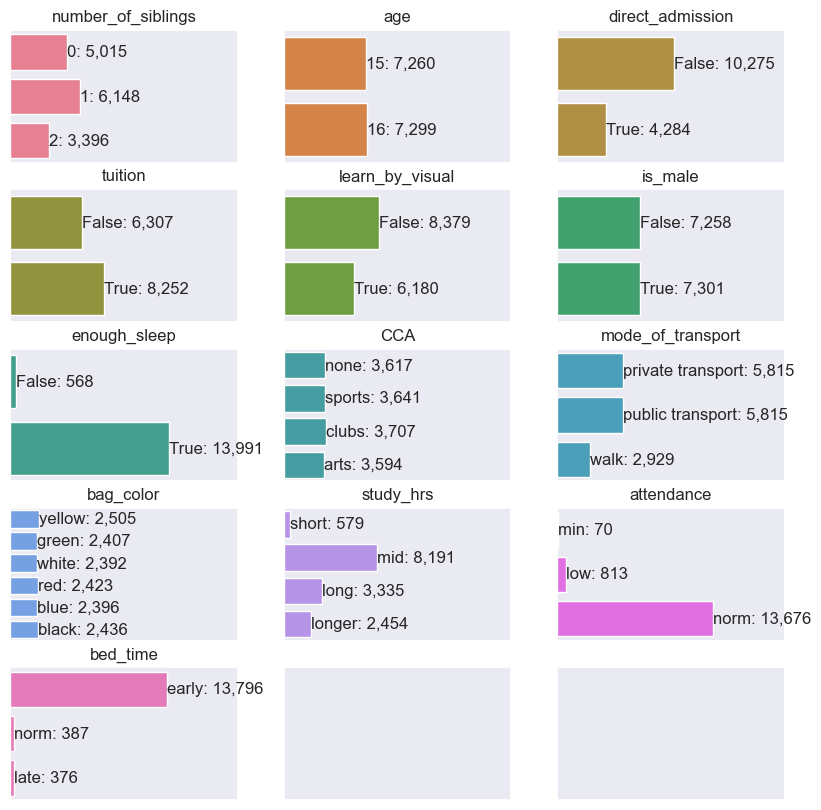

In [32]:
# check data balance
features = dis_cols + bin_cols + cat_cols
# barplot of all these features
fig, axs = plt.subplots(
    nrows=len(features)//3 if len(features)%3==0 else len(features)//3 + 1,
    ncols=3,
    figsize=(10, 10)
)
palette = iter(sns.husl_palette(len(features))) # assign different color for each subplot
for i in range(len(features)):
    feature = features[i]
    ax = axs[i//3, i%3]
    df = df_data[feature].value_counts().sort_index()
    sns.barplot(df, orient='h', ax=ax, color=next(palette))
    # add text label to bars
    rects = ax.patches
    for rect, index, value in zip(rects, df.index, df):
        width = rect.get_width()
        height = rect.get_height()
        ax.text(
            width,
            rect.get_y() + height/2,
            f'{index}: {value:,d}',
            ha='left',
            va='center'
        )
    ax.set_xlim(0, 20000) # same x range to all subplots
    ax.set(xlabel=None) # remove xlabel
    ax.set(ylabel=None) # remove ylabel
    ax.set_title(feature)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]) # remove all ticks
plt.show()

Except the features we added to identify continuous feature outliers, the rest features do NOT show significant imbalance issue.

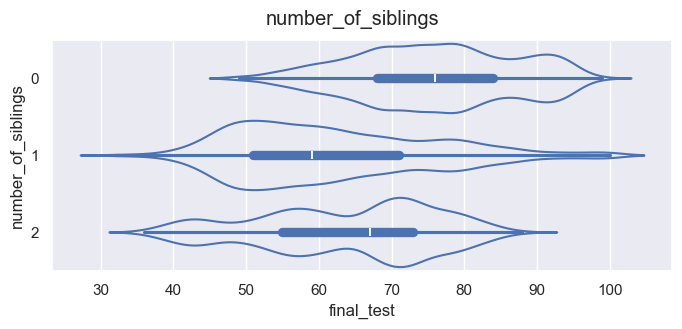

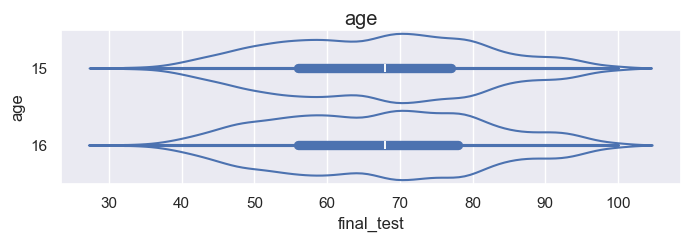

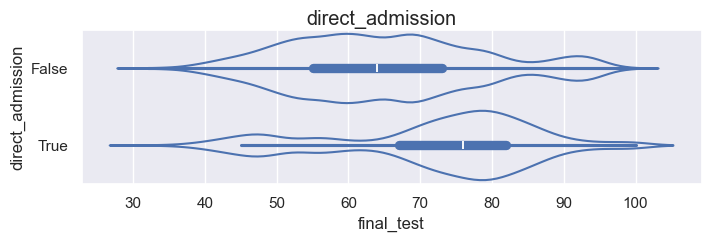

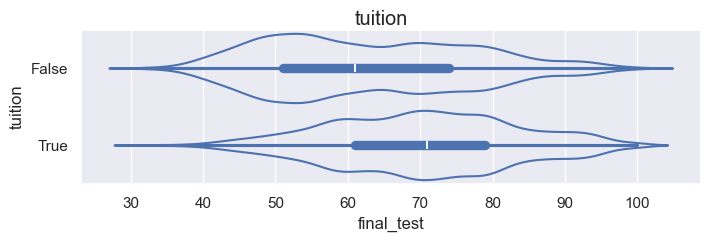

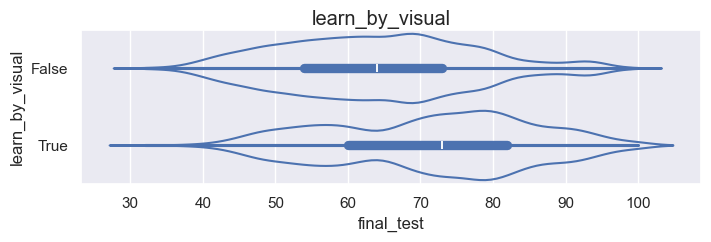

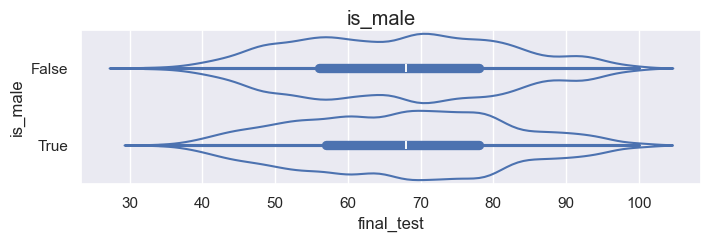

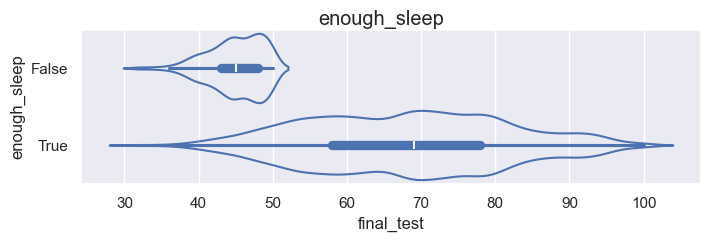

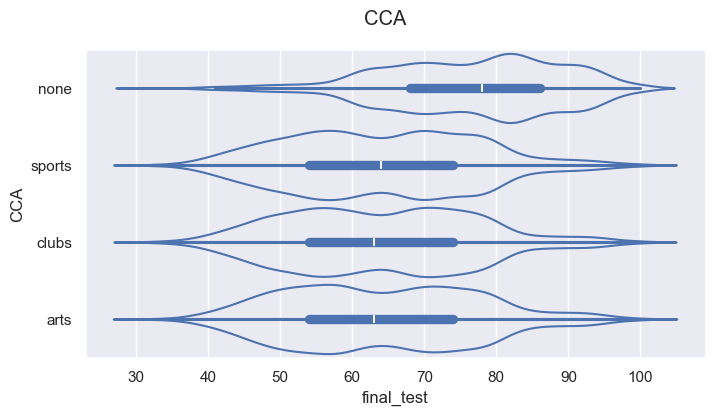

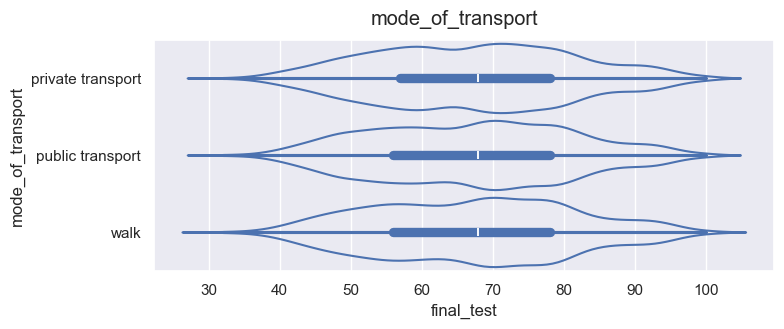

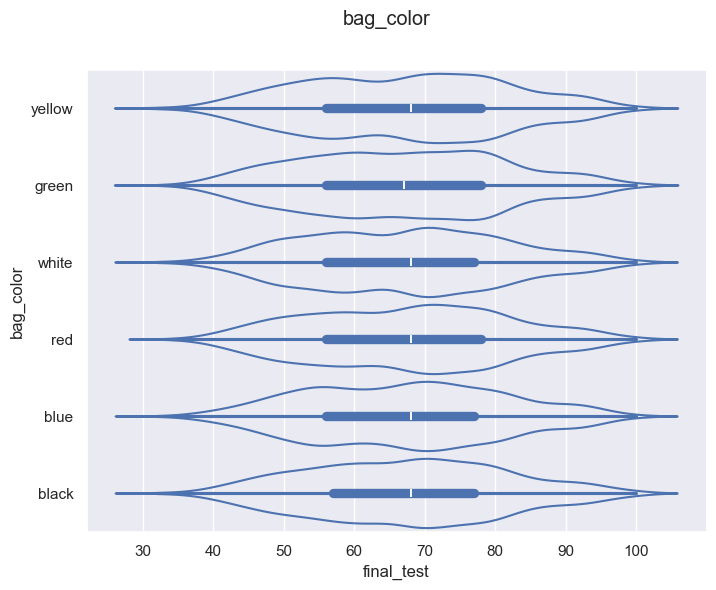

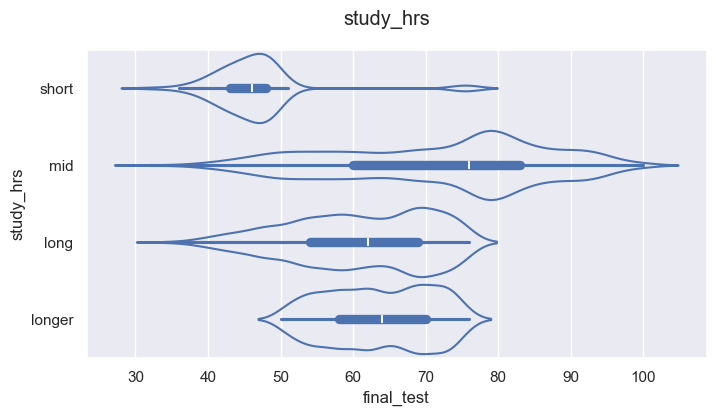

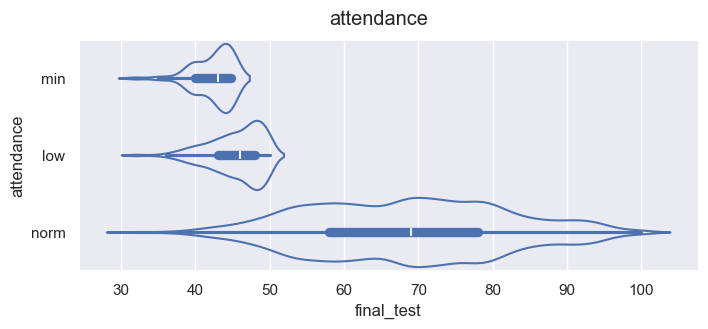

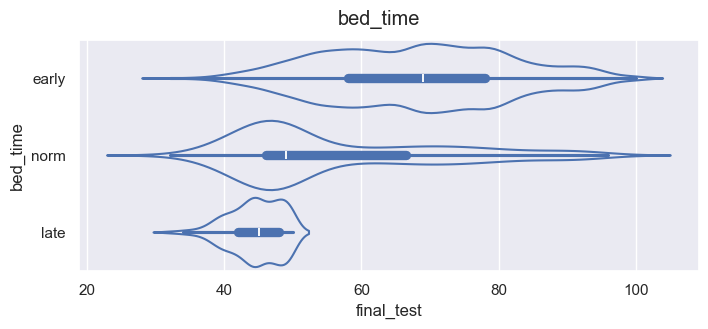

In [33]:
# check correlation with final_test
def plot_violin(feature):
    """violin plot for feature"""
    fig = plt.figure(figsize=(8, df_data[feature].nunique()))
    sns.violinplot(df_data, x='final_test', y=feature, orient='h', 
                   fill=False, width=.9, density_norm='width') 
    fig.suptitle(feature)
    plt.show()
for feature in features:
    plot_violin(feature)

- `number_of_siblings` **Medium** prediction power
    - Students with no sibling do not perform too bad.
    - Students with 2 siblings are unlikely to be top performers.
- `direct_admission` **Strong** prediction power
    - Students from direct admission are likely to perform better.
    - It suggests correlation between primary school and secondary school performance.
- `tuition` **Medium** prediction power
    - Students with tuition are less likely to be bottom performers.
    - We cannot conclude tuition can help bottom performers. Maybe they simply don't attend tuition.
- `learning_by_visual` **Medium** prediction power
    - Students with learning style of visual show slightly better performance.
- `CCA` **Medium** prediction power
    - Students without any CCA show better performance than others.
    - If they attend CCA, detailed CCA choice doesn't show significant effect on test score.
    - We cannot conclude that not attending CCA is a key parameter, maybe they just have more time to study or attending tuition.
- `mode_of_transport`, `gender` and `bag_color` show **weak** prediction power

### Interaction relationship between prediction features

Now we explore the interaction relationship between prediction features. For those with strong interaction, we can further explore how their interaction affect the predicitoin power.

We will study the **feature interaction significance** in below 3 ways.  
1. Linear correlation coefficient
2. Linear correlation on rank
    - This method can reflect if the features follow same trend, not necessarily linear. It is also more robust to outlier compare to the conventional Pearson coefficient.
3. Mutual information
    - This method tells you if 2 features have relationship or totally independent. Though you won't know what kind of relationship if any.

Note on **data preparation** for correlation study:  
- All categorical features will be encoded.
    - Either label encoded or one hot encoded depend on if the feature is ordinal or not.
- We need to decide if the features should be treated as discrete or continuous for mutual info calculation.
    - Consider the sample size (14,559) and number of unique values of each feature (max 308 'male_ratio', all others <100), it is reasonable to treat all of them as discrete.
    - All categorical features should be label encoded. As mutual info can detect any kind of relationship, there is no point to one hot encoding even if there is no order in the categories.

In [34]:
# prepare data frame for correlation study
df_corr = df_data[targets + num_cols + dis_cols + bin_cols] # all numeric features
for feature in ['study_hrs', 'attendance', 'bed_time']:
    # ordinal encoded category features
    df_corr[feature] = df_data[feature].cat.codes
# one hot encoded category features
df_corr = pd.concat(
    [df_corr, 
     pd.get_dummies(df_data[['CCA', 'mode_of_transport', 'bag_color']],
                    prefix=['CCA', '', 'bag'])
    ],
    axis=1
)

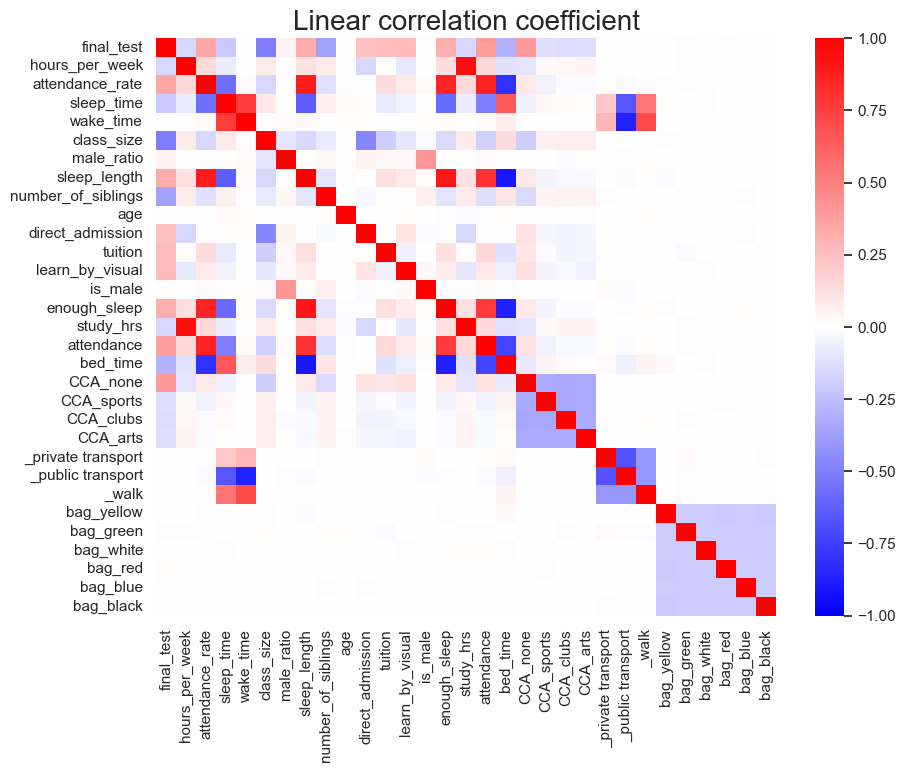

In [35]:
# plot heatmap for linear correlation coefficient
fig = plt.figure(figsize=(10, 7.5))
sns.heatmap(df_corr.corr(), cmap='bwr', vmin=-1, vmax=1)
plt.title('Linear correlation coefficient', fontsize=20)
plt.show()

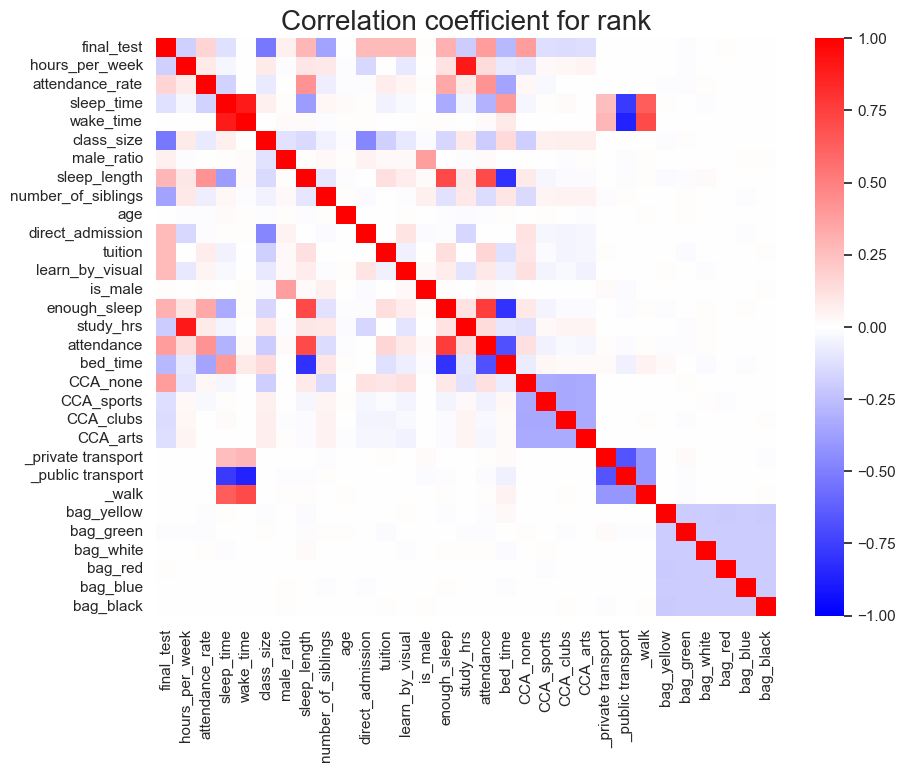

In [36]:
# plot heatmap of correlation coefficient for rank
fig = plt.figure(figsize=(10, 7.5))
sns.heatmap(df_corr.rank(axis=0).corr(), cmap='bwr', vmin=-1, vmax=1)
plt.title('Correlation coefficient for rank', fontsize=20)
plt.show()

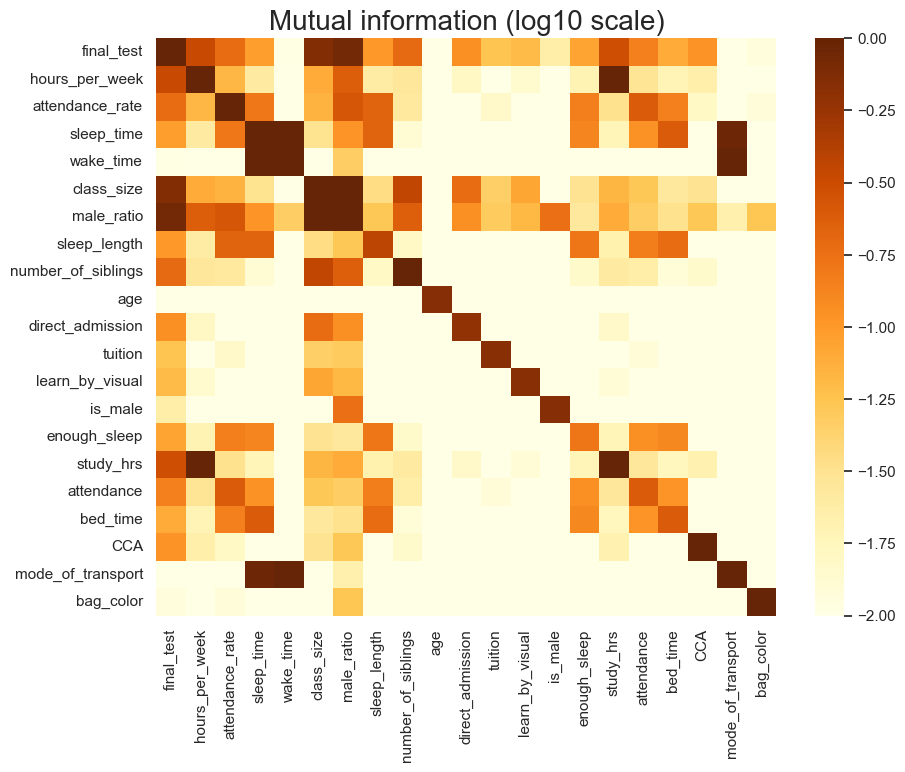

In [37]:
# convert all features to category and put codes in df_mut
df_mut = df_data[targets + num_cols + dis_cols + bin_cols + 
                 cat_cols[3:] + cat_cols[:3]] # same sequence as linear correlation above
# fill attendance_rate null with population median
df_mut['attendance_rate'] = df_mut['attendance_rate'].\
                            fillna(df_mut['attendance_rate'].median())
# treat all features as category type and label encoded
for feature in targets + num_cols + dis_cols + bin_cols:
    df_mut[feature] = pd.Categorical(df_mut[feature])
for feature in df_mut.columns:
    df_mut[feature] = df_mut[feature].cat.codes
# calculate mutual info
mut_info = []
for feature in df_mut.columns:
    mut_info.append(
        pd.Series(
            data=mutual_info_classif(df_mut, df_mut[feature], 
                                     discrete_features=True
                                     ),
            index=df_mut.columns,
            name=feature
        )
    )
# plot heatmap
fig = plt.figure(figsize=(10, 7.5))
# sns.heatmap(pd.concat(mut_info, axis=1), vmin=0, vmax=.5, cmap='YlOrBr')
sns.heatmap(np.log10(pd.concat(mut_info, axis=1)), vmin=-2, vmax=0, cmap='YlOrBr')
plt.title('Mutual information (log10 scale)', fontsize=20)
plt.show()

We have many interesting findings.

#### 1. Most important prediction features of `final_test`

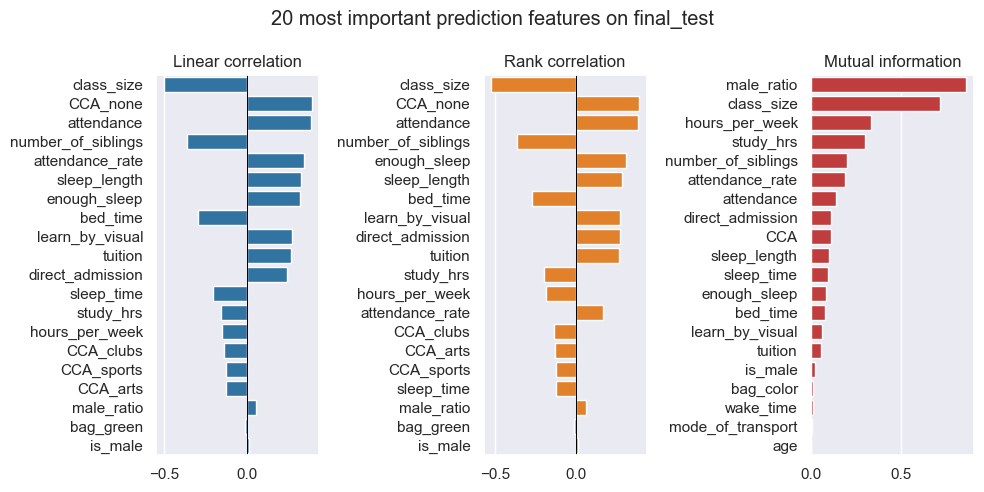

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(10,5))
# linear correlation coefficient
df = df_corr.corr()[['final_test']].iloc[1:,:]
df['abs'] = df['final_test'].abs()
df.sort_values('abs', ascending=False, inplace=True)
sns.barplot(df.iloc[:20,0], orient='h', 
            color='tab:blue', ax=axs[0])
axs[0].axvline(0, color='black', lw=0.75)
axs[0].set_title('Linear correlation')
axs[0].set_xlabel(None)
# rank correlation coefficient
df = df_corr.rank(axis=0).corr()[['final_test']].iloc[1:,:]
df['abs'] = df['final_test'].abs()
df.sort_values('abs', ascending=False, inplace=True)
sns.barplot(df.iloc[:20,0], orient='h', 
            color='tab:orange', ax=axs[1])
axs[1].axvline(0, color='black', lw=0.75)
axs[1].set_title('Rank correlation')
axs[1].set_xlabel(None)
# Mutual information
df = mut_info[0].to_frame().iloc[1:,:]
df['abs'] = df['final_test'].abs()
df.sort_values('abs', ascending=False, inplace=True)
sns.barplot(df.iloc[:20,0], orient='h', 
            color='tab:red', ax=axs[2])
axs[2].set_title('Mutual information')
axs[2].set_xlabel(None)
fig.suptitle('20 most important prediction features on final_test')
fig.tight_layout()
plt.show()


#### 2. Longer study time results in lower score?

`hours_per_week` shows weak **negative** correlation to `final_test`, which does NOT make sense logically. Mutual info shows strong relationship between them, indicating the existence of nonlinear pattern.

As discussed previously, top students don't study long time. So a logical explanation is longer study time can improve test result, but many medium to low quality students study much longer skewing the total correlation.

#### 3. Class gender ratio effect

`male_ratio` shows very weak linear correlation with `final_test`, but their mutual info is very strong. Actually `male_ratio` shows weak linear correlation to all other features (except `is_male` only), but mutual info are mostly strong.

It is also strange that `male_ratio` has high mutual info with both `final_test` and `is_male`, but the mutal info between `final_test` and `is_male` is quite low.

Below plot shows the cause:

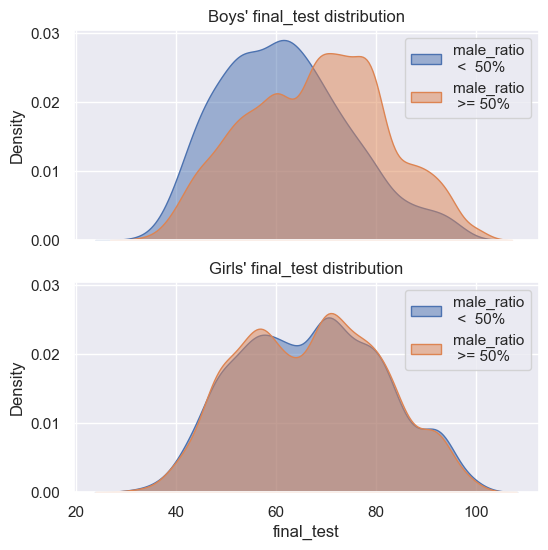

In [39]:
# plot score distribution according to gender and class gender distribution
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(6, 6))
sns.kdeplot(df_data[(df_data['is_male']==True) & (df_data['male_ratio']<0.5)], 
            x='final_test', 
            label='male_ratio\n <  50%',
            fill=True,
            alpha=0.5,
            ax=axs[0])
sns.kdeplot(df_data[(df_data['is_male']==True) & (df_data['male_ratio']>=0.5)], 
            x='final_test', 
            label='male_ratio\n >= 50%',
            fill=True,
            alpha=0.5,
            ax=axs[0])
axs[0].legend()
axs[0].set_title("Boys' final_test distribution")
sns.kdeplot(df_data[(df_data['is_male']==False) & (df_data['male_ratio']<0.5)], 
            x='final_test', 
            label='male_ratio\n <  50%',
            fill=True,
            alpha=0.5,
            ax=axs[1])
sns.kdeplot(df_data[(df_data['is_male']==False) & (df_data['male_ratio']>=0.5)], 
            x='final_test', 
            label='male_ratio\n >= 50%',
            fill=True,
            alpha=0.5,
            ax=axs[1])
axs[1].legend()
axs[1].set_title("Girls' final_test distribution")
plt.show()

- Male students' score distributions show clear difference between male dominant classes and female dominant classes.
- Female students' score distributions are comparable and less dependent on gender distribution in class.
- Boys as a whole do NOT show significant difference from girls in performance distribution.
- It worths digging why class gender distribution is related to boys' performance distribution.

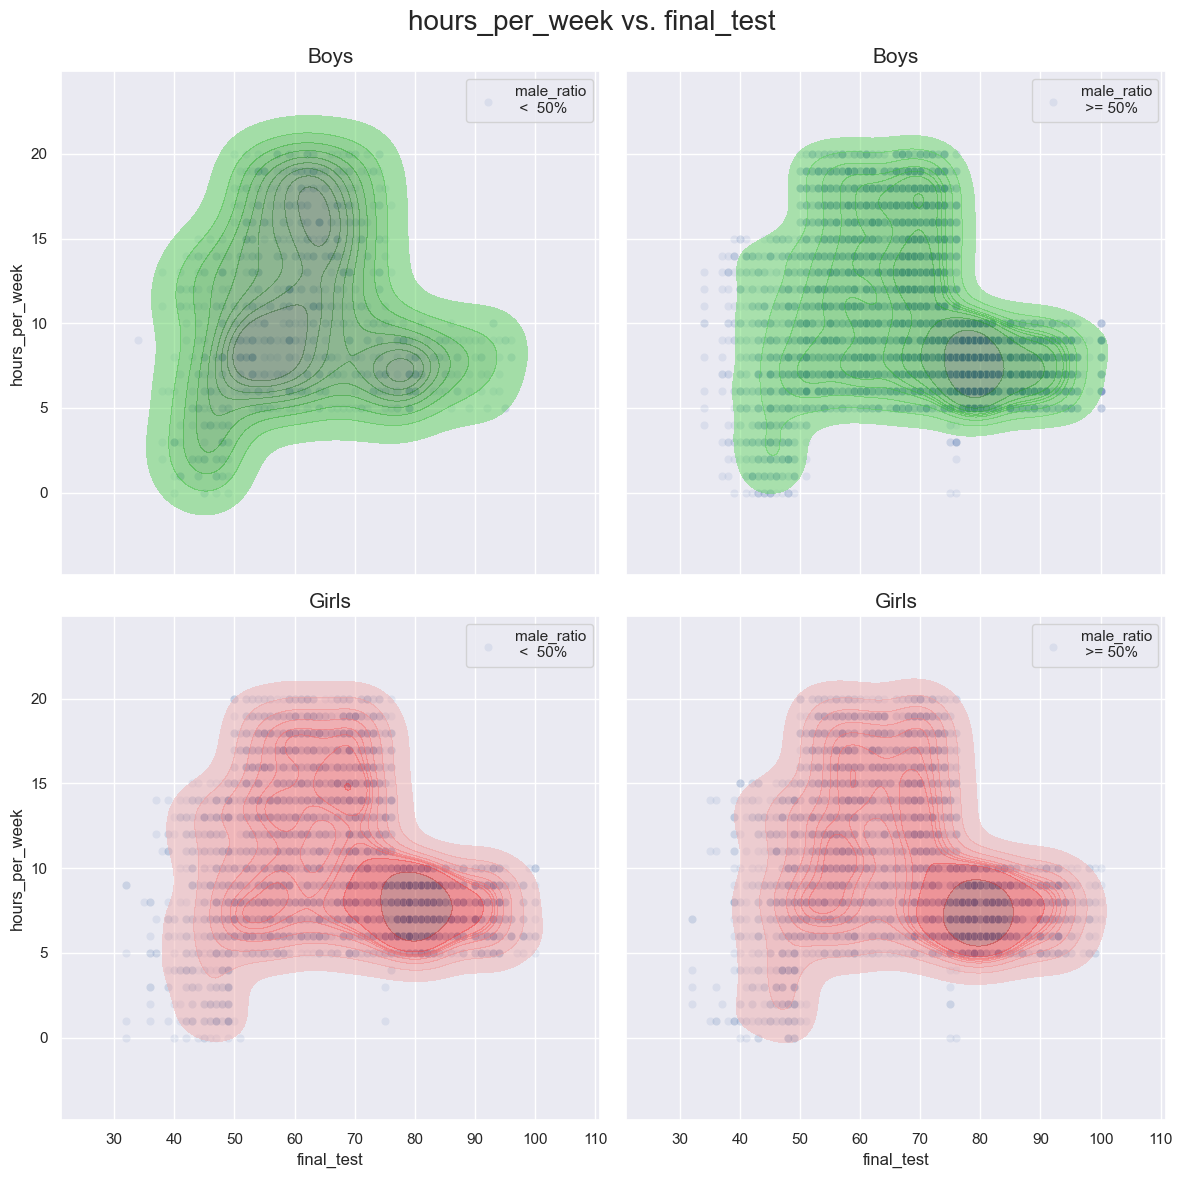

In [40]:
# plot study hrs vs. score according to gender and class gender distribution
fig, axs = plt.subplots(2, 2, sharey=True, sharex=True, figsize= (12, 12))
sns.scatterplot(df_data[(df_data['is_male']==True) & (df_data['male_ratio']<0.5)], 
                y='hours_per_week', x='final_test', alpha=0.1, ax=axs[0,0],
                label='male_ratio\n <  50%')
sns.kdeplot(df_data[(df_data['is_male']==True) & (df_data['male_ratio']<0.5)], 
            y='hours_per_week', x='final_test', color='tab:green', 
            fill=True, alpha=0.5, ax=axs[0,0],
            label='male_ratio\n <  50%')
sns.scatterplot(df_data[(df_data['is_male']==True) & (df_data['male_ratio']>=0.5)], 
                y='hours_per_week', x='final_test', alpha=0.1, ax=axs[0,1],
                label='male_ratio\n >= 50%')
sns.kdeplot(df_data[(df_data['is_male']==True) & (df_data['male_ratio']>=0.5)], 
            y='hours_per_week', x='final_test', color='tab:green', 
            fill=True, alpha=0.5, ax=axs[0,1],
            label='male_ratio\n >= 50%')
axs[0,0].set_title('Boys', fontsize=15)
axs[0,1].set_title('Boys', fontsize=15)
sns.scatterplot(df_data[(df_data['is_male']==False) & (df_data['male_ratio']<0.5)], 
                y='hours_per_week', x='final_test', alpha=0.1, ax=axs[1,0],
                label='male_ratio\n <  50%')
sns.kdeplot(df_data[(df_data['is_male']==False) & (df_data['male_ratio']<0.5)], 
            y='hours_per_week', x='final_test', color='tab:red', 
            fill=True, alpha=0.5, ax=axs[1,0],
            label='male_ratio\n <  50%')
sns.scatterplot(df_data[(df_data['is_male']==False) & (df_data['male_ratio']>=0.5)], 
                y='hours_per_week', x='final_test', alpha=0.1, ax=axs[1,1],
                label='male_ratio\n >= 50%')
sns.kdeplot(df_data[(df_data['is_male']==False) & (df_data['male_ratio']>=0.5)], 
            y='hours_per_week', x='final_test', color='tab:red', 
            fill=True, alpha=0.5, ax=axs[1,1],
            label='male_ratio\n >= 50%')
axs[1,0].set_title('Girls', fontsize=15)
axs[1,1].set_title('Girls', fontsize=15)
fig.suptitle('hours_per_week vs. final_test', fontsize=20)
fig.tight_layout()
plt.show()

- In male dominant classes there are higher ratio of top performance boys (study 5~10 hours per week while getting top score).
- Girls of difference performance distributes evenly and independent of class gender distribution.
- In male dominant classes the patterns of boys and girls are more close.

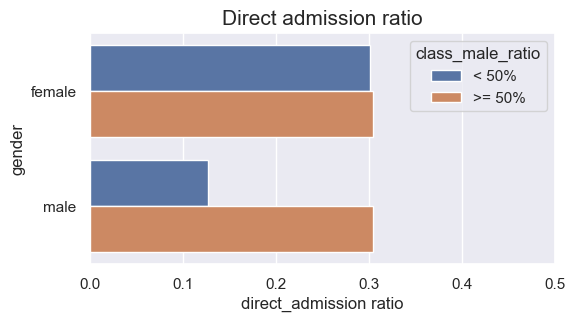

In [41]:
# plot direct_admission ratio according to gender and class gender distribution
df = df_data[['male_ratio', 'direct_admission', 'is_male']]
df['class_male_ratio'] = df['male_ratio'].apply(lambda x: '< 50%' if x < 0.5 else '>= 50%')
df = df.groupby(['is_male', 'class_male_ratio']).mean().reset_index()
df['gender'] = df['is_male'].apply(lambda x: 'male' if x==True else 'female')

fig = plt.figure(figsize=(6, 3))
sns.barplot(df, x='direct_admission', y='gender', orient='h', 
            hue='class_male_ratio')
plt.xlim(0, 0.5)
plt.xlabel('direct_admission ratio')
plt.title('Direct admission ratio', fontsize=15)
plt.show()

Above plot shows one cause of above phenomenon:  
- Direct admission rate of boys in female dominant classes is significantly lower.
- Previously we already show that `direct_admission` students show relative better `final_test` result.

In [51]:
df_data.groupby('is_male')[['direct_admission']].mean()

,direct_admission
is_male,
False,0.303114
True,0.285440


- Female has higher `direct_admission` rate than male students.

#### 4. sleep effect on final test

Sleep related features include `sleep_time`, `wake_time`, and the engineered features `sleep_length` and `bed_time`.  
- `sleep_time` and `wake_time` are strongly correlated, which is quite logical as most people sleep early if they need to get up early.
- However, `sleep_time` has significant correlation with `final_test` while `wake_time` shows almost no prediction power on it. Why? 

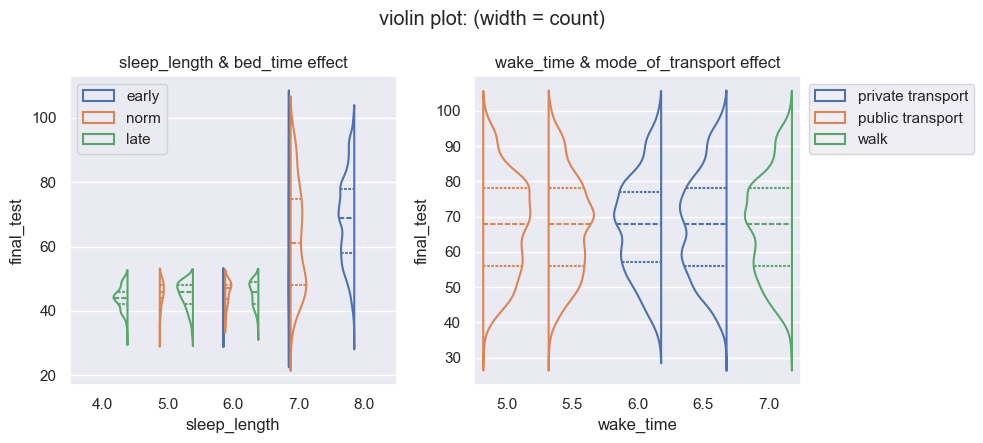

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4.5))
# plot final_test vs. sleep_length & bed_time
sns.violinplot(
    df_data, x='sleep_length', y='final_test', hue='bed_time',
    split=True, fill=False, inner='quart', gap=0.1,
    density_norm='count', ax=axs[0]
)
axs[0].legend(loc='upper left', bbox_to_anchor=(0, 1))
axs[0].set_title('sleep_length & bed_time effect')

# plot mode_of_transport vs. wake_time
sns.violinplot(
    df_data, x='wake_time', y='final_test', hue='mode_of_transport',
    split=True, fill=False, inner='quart', gap=0.1,
    density_norm='count', ax=axs[1]
)
axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
axs[1].set_title('wake_time & mode_of_transport effect')
fig.suptitle('violin plot: (width = count)')
fig.tight_layout()
plt.show()

- Not enough sleep (<7hrs) always lead to poor test result.
    - Late sleep is a major cause of not enough sleep, thus showing significant relationship to test performance.
- Wake time mainly depends on the transport mode.
    - Students decide wake time mainly based on the time needed to go to school, thus not much relationship to their test performance.

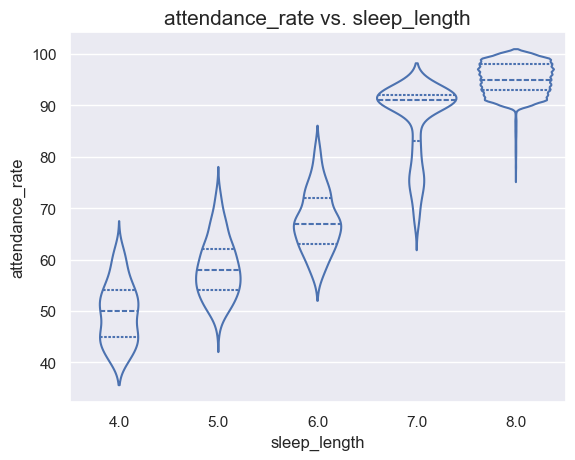

In [43]:
# plot attendance_rate vs. sleep_length
sns.violinplot(
    df_data, x='sleep_length', y='attendance_rate',
    fill=False, inner='quart'
)
plt.title('attendance_rate vs. sleep_length', fontsize=15),
plt.show()

- `attendance_rate` is strongly correlated with `sleep_length`, which is the reason of shorter `sleep_length` leads to poorer `final_test` result.

**Idea of fill `attendance_rate` null values**  
- Since `sleep_length` is a strong predictor of `attendance_rate`, their correlation can be used to fill `attendance_rate` null values.

#### 5. attendance, tuition & study length effect

Why low `attendance_rate` has so significant negative effect on `final_test` result?  
- I think low `attendance_rate` can have 2 reasons:
    1. **Attitude** issue: the student simply don't like school or study
    2. Other reasons (e.g. health issue)

Let's explore more from below plot.

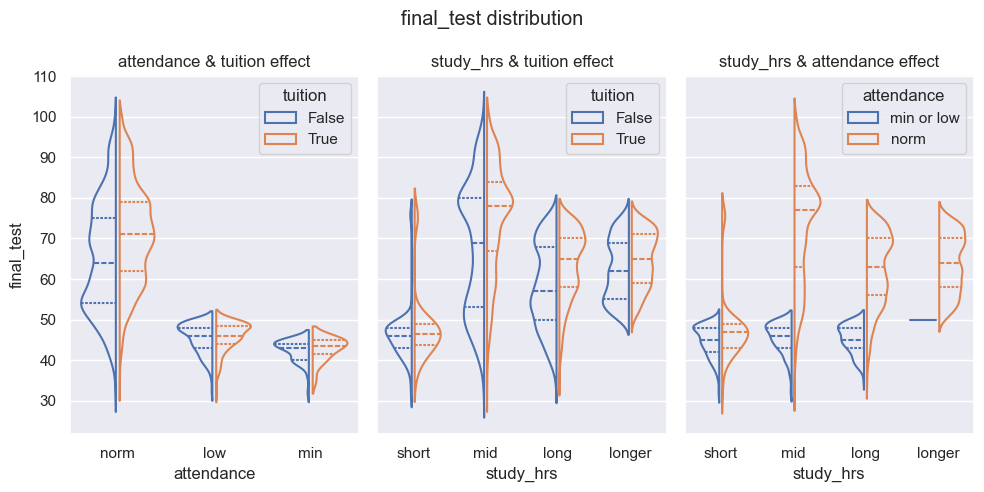

In [44]:
# plot final_test vs. attendance, study_hrs, tuition
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10,5))
sns.violinplot(df_data, x='attendance', y='final_test', hue='tuition',
               split=True, fill=False, gap=0.1, inner='quart',
               order=df_data['attendance'].cat.categories[::-1],
               ax=axs[0], density_norm='width')
sns.violinplot(df_data, x='study_hrs', y='final_test', hue='tuition',
               split=True, fill=False, gap=0.1, inner='quart',
            #    order=df_data['study_hrs'].cat.categories[::-1],
               ax=axs[1], density_norm='width')
sns.violinplot(df_data, x='study_hrs', y='final_test', 
               hue=df_data['attendance'].apply(lambda x: 'norm' if x=='norm' else 'min or low'), 
               split=True, fill=False, gap=0.1, inner='quart',
            #    order=df_data['study_hrs'].cat.categories[::-1],
               ax=axs[2], density_norm='width')
fig.suptitle('final_test distribution')
axs[0].set_title('attendance & tuition effect')
axs[1].set_title('study_hrs & tuition effect')
axs[2].set_title('study_hrs & attendance effect')
fig.tight_layout()
plt.show()

- When `attendance` is below `norm` level, tuition or longer study time cannot improve the student's performance.
- On contrary, when `attendance` is `norm` level, both tuition and longer study time have significant effect.
- Data indicate that most students with abnormal `attendance` have attitude issue.
    - Even if they attend tuition or study longer, it's likely against their will (e.g. forced by parents), thus no effect.

#### 6. `direct_admission`

Students with `direct_admission` seems more likely to have higher potential, as shown in the plot below:

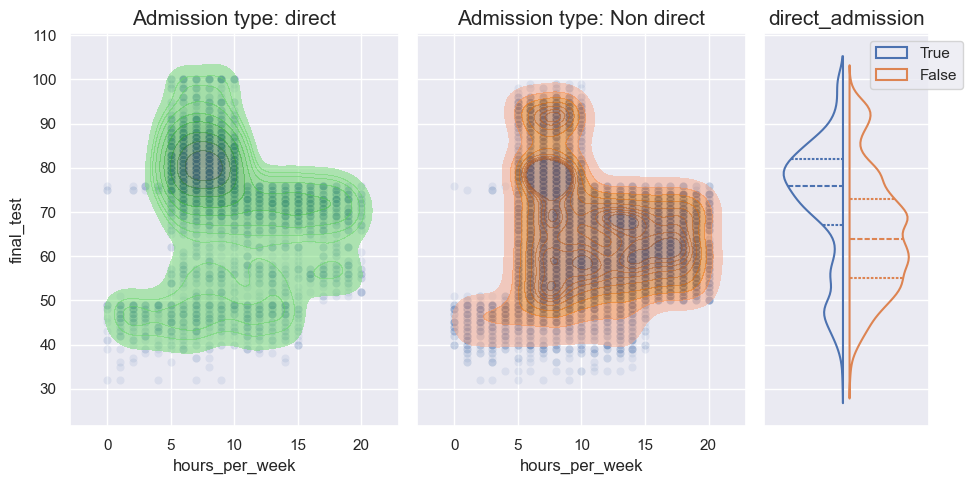

In [45]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10, 5),
                        width_ratios=[4, 4, 2])
sns.scatterplot(
    df_data[df_data['direct_admission']==True], 
    x='hours_per_week', y='final_test',
    alpha=0.1, ax=axs[0]
)
sns.kdeplot(
    df_data[df_data['direct_admission']==True], 
    x='hours_per_week', y='final_test',
    color='tab:green', fill=True, alpha=0.5,
    ax=axs[0]
)
sns.scatterplot(
    df_data[df_data['direct_admission']==False], 
    x='hours_per_week', y='final_test',
    alpha=0.1, ax=axs[1]
)
sns.kdeplot(
    df_data[df_data['direct_admission']==False], 
    x='hours_per_week', y='final_test',
    color='tab:orange', fill=True, alpha=0.5,
    ax=axs[1]
)
axs[0].set_title('Admission type: direct', fontsize=15)
axs[1].set_title('Admission type: Non direct', fontsize=15)
sns.violinplot(
    df_data, y='final_test', hue='direct_admission',
    split=True, fill=False, inner='quart', gap=0.1,
    ax=axs[2], hue_order=[True, False]
)
axs[2].legend(loc='upper left', bbox_to_anchor=(0.6, 1))
axs[2].set_title('direct_admission', fontsize=15)
fig.tight_layout()
plt.show()

- Most of the `direct_admission` students cluster in the zone of 5~10hrs study hours per week and high test score.
- Non `direct_admission` students cover the whole population distribution range.

#### 7. Special group: short `study_hrs` but mediocre performance

From `final_test` vs. `hours_per_week` scatter plot we can see a special group who study very little (<5hrs per week) but can get mediocre score of ~75, which most other students study so little cannot get score higher than 50.

Let's study what is so special of this group.

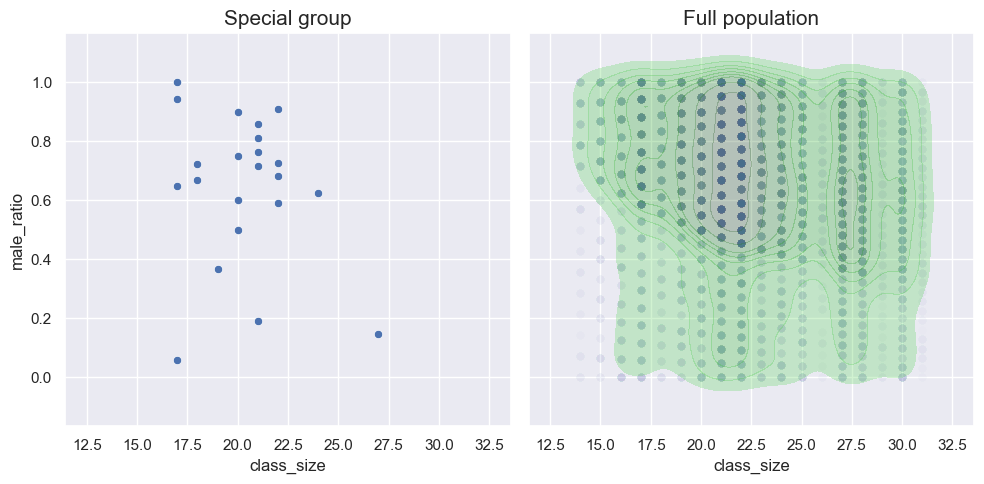

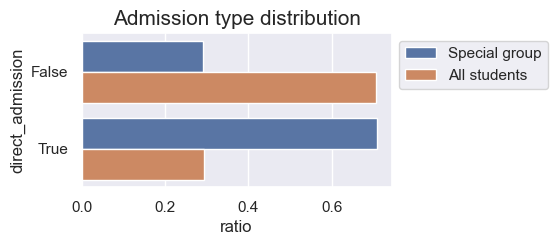

In [46]:
# data of special group
df_special = df_data[(df_data['hours_per_week']<5) & (df_data['final_test']>70)]

# plot male_ratio vs. class_size
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
sns.scatterplot(
    df_special, x='class_size', y='male_ratio',
    ax=axs[0]
)
sns.scatterplot(
    df_data, x='class_size', y='male_ratio',
    ax=axs[1], alpha=0.01
)
sns.kdeplot(
    df_data, x='class_size', y='male_ratio',
    color='tab:green', ax=axs[1],
    fill=True, alpha=0.3
)
axs[0].set_title('Special group', fontsize=15)
axs[1].set_title('Full population', fontsize=15)
fig.tight_layout()
plt.show()

# plot direct_admission distribution
series1 = df_special['direct_admission'].value_counts(normalize=True)
series1.name = 'Special group'
series2 = df_data['direct_admission'].value_counts(normalize=True)
series2.name = 'All students'
df = pd.concat([series1, series2], axis=1)
df = pd.melt(
    df.reset_index(),
    id_vars=['direct_admission'],
    value_vars=['Special group', 'All students'],
    var_name='type',
    value_name='ratio'
)

fig = plt.figure(figsize=(4,2))
ax = sns.barplot(
    df, y='direct_admission', x='ratio', 
    hue='type', orient='h'
)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Admission type distribution', fontsize=15)
plt.show()

- More than 70% of the special group students are from `direct_admission`, compare to merely 30% `direct_admission` rate of all students.
- The special group are mostly in small classes dominant by male.
    - I mean their classes have high `male_ratio`.
    - The gender distribution of this special group is quite balanced (male 54%).
- All special group students have enough sleep and good attendance rate. (Not shown in plots, but easy to find out.)
- Above characterics suggest this special group are all **high potential** kids, though the fact that they ignore study after school (low study hours per week) results in mediocre test outcome.

#### 8. `CCA` effect

In Singapore `CCA` stands for Co-Curricular Activities. From correlation matrix we can observe that students not taking any `CCA` perform better than others. Is `CCA` really a cause of `final_test` performance?

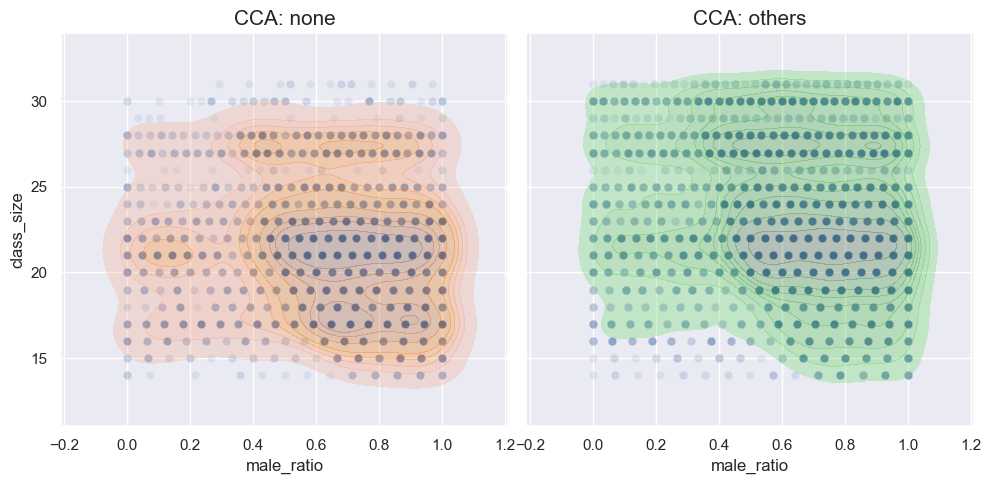

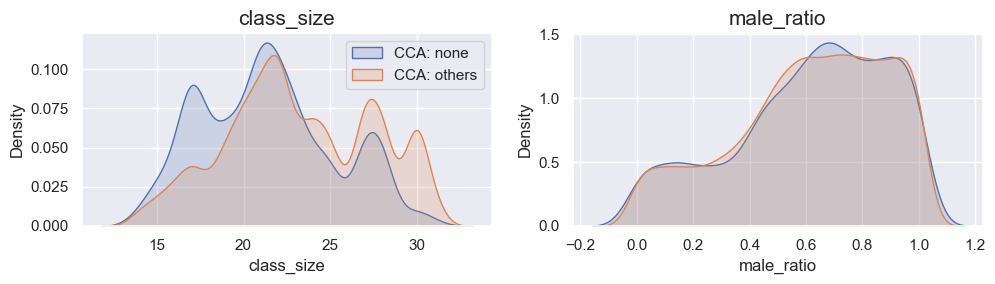

In [47]:
none_CCA = df_data['CCA'] == 'none'
none_CCA.name = 'None CCA'

# plot class_size vs. male_ratio
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
sns.scatterplot(
    df_data[none_CCA], x='male_ratio', y='class_size',
    ax=axs[0], alpha=0.1
)
sns.kdeplot(
    df_data[none_CCA], x='male_ratio', y='class_size',
    color='tab:orange', ax=axs[0],
    fill=True, alpha=0.3
)
sns.scatterplot(
    df_data[~none_CCA], x='male_ratio', y='class_size',
    ax=axs[1], alpha=0.05
)
sns.kdeplot(
    df_data[~none_CCA], x='male_ratio', y='class_size',
    color='tab:green', ax=axs[1],
    fill=True, alpha=0.3
)
axs[0].set_title('CCA: none', fontsize=15)
axs[1].set_title('CCA: others', fontsize=15)
fig.tight_layout()
plt.show()

# kde comparison
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
sns.kdeplot(
    df_data[none_CCA],
    x='class_size',
    label='CCA: none',
    fill=True,
    alpha=0.2,
    ax=axs[0]
)
sns.kdeplot(
    df_data[~none_CCA],
    x='class_size',
    label='CCA: others',
    fill=True,
    alpha=0.2,
    ax=axs[0]
)
sns.kdeplot(
    df_data[none_CCA],
    x='male_ratio',
    label='CCA: none',
    fill=True,
    alpha=0.2,
    ax=axs[1]
)
sns.kdeplot(
    df_data[~none_CCA],
    x='male_ratio',
    label='CCA: others',
    fill=True,
    alpha=0.2,
    ax=axs[1]
)
axs[0].set_title('class_size', fontsize=15)
axs[1].set_title('male_ratio', fontsize=15)
axs[0].legend()
# axs[1].legend()
fig.tight_layout()
plt.show()

- Students from smaller class are more likely to take none `CCA`.

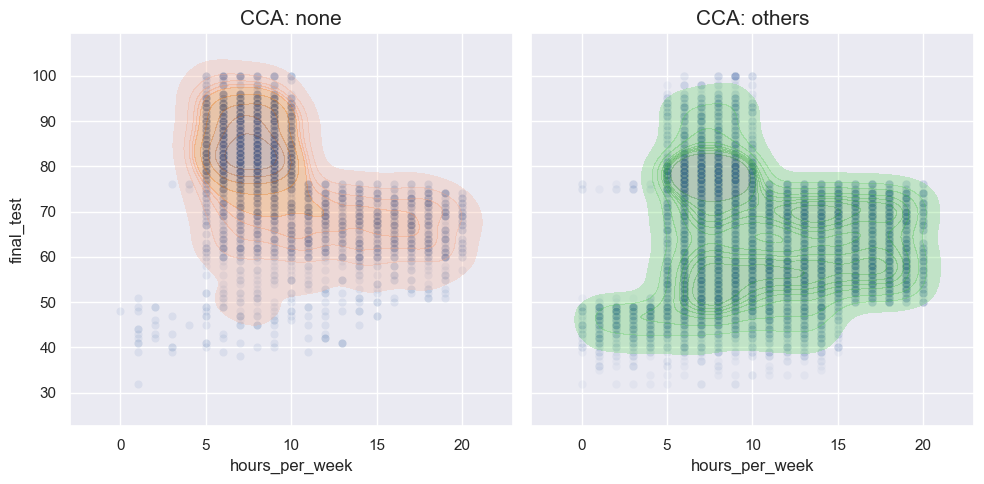

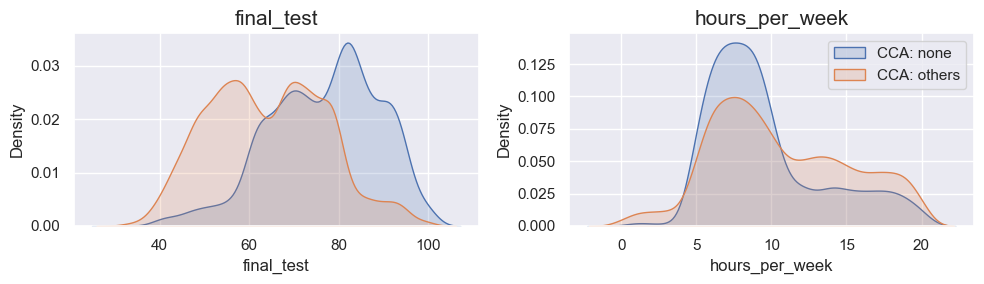

In [48]:
# plot final_test vs. hours_per_week
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
sns.scatterplot(
    df_data[none_CCA], x='hours_per_week', y='final_test',
    ax=axs[0], alpha=0.1
)
sns.kdeplot(
    df_data[none_CCA], x='hours_per_week', y='final_test',
    color='tab:orange', ax=axs[0],
    fill=True, alpha=0.3
)
sns.scatterplot(
    df_data[~none_CCA], x='hours_per_week', y='final_test',
    ax=axs[1], alpha=0.05
)
sns.kdeplot(
    df_data[~none_CCA], x='hours_per_week', y='final_test',
    color='tab:green', ax=axs[1],
    fill=True, alpha=0.3
)
axs[0].set_title('CCA: none', fontsize=15)
axs[1].set_title('CCA: others', fontsize=15)
fig.tight_layout()
plt.show()

# kde comparison
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
sns.kdeplot(
    df_data[none_CCA],
    x='final_test',
    label='CCA: none',
    fill=True,
    alpha=0.2,
    ax=axs[0]
)
sns.kdeplot(
    df_data[~none_CCA],
    x='final_test',
    label='CCA: others',
    fill=True,
    alpha=0.2,
    ax=axs[0]
)
sns.kdeplot(
    df_data[none_CCA],
    x='hours_per_week',
    label='CCA: none',
    fill=True,
    alpha=0.2,
    ax=axs[1]
)
sns.kdeplot(
    df_data[~none_CCA],
    x='hours_per_week',
    label='CCA: others',
    fill=True,
    alpha=0.2,
    ax=axs[1]
)
axs[0].set_title('final_test', fontsize=15)
axs[1].set_title('hours_per_week', fontsize=15)
# axs[0].legend()
axs[1].legend()
fig.tight_layout()
plt.show()

- Students with high `final_test` score are more likely to take none `CCA`.
- Students poor in `final_test` are more acitive in `CCA`.

In [49]:
# compare tuition ratio and gender distribution
df = pd.concat([df_data[['tuition', 'is_male']], none_CCA], axis=1)
df.groupby('None CCA').mean()

,tuition,is_male
None CCA,,
False,0.538933,0.501097
True,0.651092,0.502626


- Maybe some students don't take `CCA` as they need time for `tuition`.
- No significant gender imbalance.

#### 9. `number_of_siblings` effect

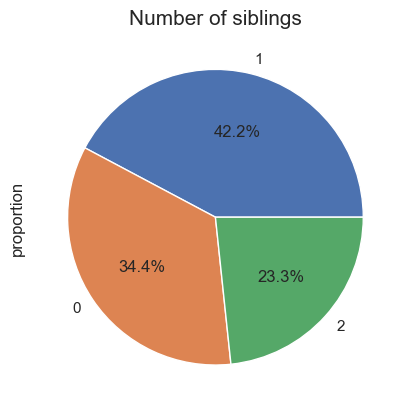

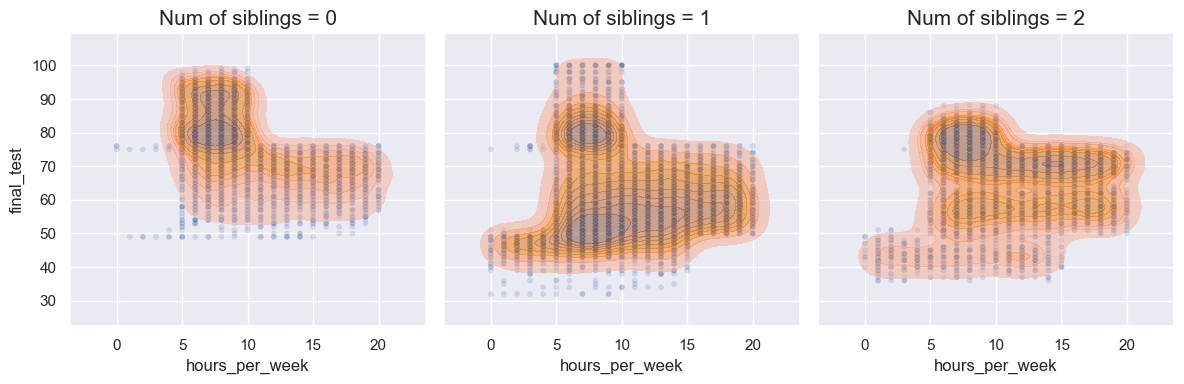

In [60]:
# plot number_of_siblings distribution
df_data['number_of_siblings'].value_counts(normalize=True).plot.pie(autopct='%1.1f%%')
plt.title('Number of siblings', fontsize=15)
plt.show()

# plot final_test vs. hours_per_week for each number_of_siblings
fig, axs = plt.subplots(
        nrows=1,
        ncols=3,
        sharex=True,
        sharey=True,
        figsize=(12, 4)
)
for i in range(3):
    sns.scatterplot(
        data=df_data[df_data['number_of_siblings']==i],
        x='hours_per_week',
        y='final_test',
        size=1,
        ax=axs[i],
        alpha=.2
    )
    axs[i].get_legend().remove()
    sns.kdeplot(
        data=df_data[df_data['number_of_siblings']==i],
        x='hours_per_week',
        y='final_test',
        color='tab:orange',
        ax=axs[i],
        fill=True,
        alpha=.5
    )
    axs[i].set_title(f'Num of siblings = {i}', fontsize=15)
fig.tight_layout()
plt.show()

- Worst performers tend to have 1 or 2 siblings.
- Best performers tend to have 0 or 1 sibling.
- The cause of number of sibling effect is likely the amount of attentions from parents.

#### 10. Unimportant features

- **Most** unimportant features  
    - `age`, `bag_color`: we can safely drop them from our models
- **Potential** unimportant features
    - `wake_time`, `mode_of_transport`
    - Though not showing relationship to target, they do have some relationship to `sleep_time` which is correlated with target.
    - Previous discussion shows that `sleep_length` is the key, so likely even `sleep_time` is not important.
    - To play safe, better keep these features in model building. Later we can use the trained model to further study their importance (e.g. permutation importance, SHAP value, etc.) and decide if it is better to drop them.
- **NOTE**
    - `gender` do NOT show correlation to target, but it is important since its interaction term with class `male_ratio` shows prediction power.

## Summary

### Key data cleaning findings

- `sleep_time` & `wake_time` are string type, need to convert to time or number.
- `tuition` has inconsistent entry ['no' 'yes' 'y' 'n'].
- Found duplicated `student_id`, mostly have inconsistent `bag_color` or `attendance_rate`.
- `attendance_rate` has null values.

### EDA highlights

- `final_test` score drive factors (they have significant prediction power, but not necessary cause of test result)
    - Positive features
        - `CCA_none`, `attendance_rate`, `sleep_length`, `tuition`, `direct admission`, `learn_by_visual`, `male_ratio`
        - `hours_per_week`
            - Please note the correlation between `hours_per_week` and `final_test` is negative, but I believe it has positive effect. The reason of negative coefficient is due to the student populatoin is a mixture of many types.
    - Negative features
        - `class_size`, `number_of_siblings`, sleep_time`
- Student classification: 3 types
    1. High potential
        - Can achieve good `final_test` result with only 5~10 hrs study per week. Even if they don't actively study (0~5 hrs per week) after school, still can get mediocre test result (~75).
            - They don't study more than 10 hrs per week. It is simply not necessary.
        - They are less active in `CCA` and many choose to NOT take any `CCA`
        - Students with `direct_admission` are more likely to be with high potential.
        - Smaller `class_size` and classes with higher male ratio (>50%) have more high potential students. 
    2. Norminal potential
        - Their test results significantly depend on their effort (attend `tuition` and longer study time). But it is almost impossible for them to get top score (>80) even if they study as long as 15~20 hrs per week.
    3. With attitude issue
        - These students typically have lower than normal attendance rate, due to late bed time and not enough sleep.
        - Even if they take `tuition` or study for long time (likely forced by parent?), the effective is NOT significant.
        - Though don't like school, they are surprisingly more active in `CCA`.
- Class gender distribution effect
    - Generally speaking there is no significant difference between boy and girl populations.
    - However male students from male dominant (>50%) classes tend to perform better than male students from female dominant classes.
        - No such difference can be observed on female students.
    - One reason is that the ratio of male students from `direct_admission` is much lower in female dominant classes than male dominant classes.
        - `direct_admission` ratio of boys in male dominant classes and girls in both male dominant and female dominant classes are comparable.
    - At this moment it is difficult to conclude if class gender ratio has any significant impact on males' test performance or not.
- Family effect
    - Top performers come mostly from families with 0 or 1 siblings.
    - Worst performers come mostly from families with 1 or 2 siblings.
    - Amount of parent attention is likely the key.